<a href="https://colab.research.google.com/github/ehsanbarkhordar/Bank-Customer-Clustering-By-Transactions/blob/main/Czech_customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Input, Embedding, TimeDistributed, Dropout,Bidirectional,Concatenate
from keras.layers import LSTM, Reshape,multiply,dot, maximum,merge,Activation,MaxPool1D,AveragePooling1D,Add,Permute,RepeatVector, Lambda,average ,Embedding, Dense, TimeDistributed, Dropout, Bidirectional,BatchNormalization,Conv1D,Flatten, Concatenate
from keras.layers.advanced_activations import PReLU,LeakyReLU
from keras.optimizers import SGD
from tensorflow.keras.utils import plot_model


import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


In [11]:
# Import Clients
path='/content/gdrive/MyDrive/lpetrocelli-retail-banking-demo-data/completedclient.csv'
df_completedclient = pd.read_csv(path, low_memory=False)
df_completedclient = df_completedclient.loc[:, ~df_completedclient.columns.str.contains('^Unnamed')]
df_completedclient

,client_id,sex,fulldate,day,month,year,age,social,first,middle,last,phone,email,address_1,address_2,city,state,zipcode,district_id
0,C00000001,Female,1990-12-13,13,12,1990,29,926-93-2157,Emma,Avaya,Smith,367-171-6840,emma.smith@gmail.com,387 Wellington Ave.,Unit 1,Albuquerque,NM,47246,18
1,C00000002,Male,1965-02-04,4,2,1965,54,806-94-5725,Noah,Everest,Thompson,212-423-7734,noah.thompson@gmail.com,75 W. Berkshire St.,NaN,New York City,NY,10040,1
2,C00000003,Female,1960-10-09,9,10,1960,59,614-70-9100,Olivia,Brooklynne,Johnson,212-425-6932,olivia.johnson@outlook.com,36 Second St.,NaN,New York City,NY,10162,1
3,C00000004,Male,1976-12-01,1,12,1976,43,580-20-3414,Liam,Irvin,White,951-567-8925,liam.white@gmail.com,7607 Sunnyslope Street,NaN,Indianapolis,IN,49047,5
4,C00000005,Female,1980-07-03,3,7,1980,39,536-14-5809,Sophia,Danae,Williams,428-265-1568,sophia.williams@gmail.com,755 Galvin Street,NaN,Indianapolis,IN,40852,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5364,C00013955,Female,1965-10-30,30,10,1965,54,830-38-3530,Adrianna,Jillian,Moore,212-205-7422,adrianna.moore@outlook.com,9405 SW. Leeton Ridge Drive,NaN,New York City,NY,10121,1
5365,C00013956,Male,1963-04-06,6,4,1963,56,773-25-4409,Aaron,Roman,Park,212-645-8820,aaron.park@gmail.com,7021 Chapel Ave.,NaN,New York City,NY,10118,1
5366,C00013968,Male,1988-04-13,13,4,1988,31,227-17-0778,Eli,Leonardo,Warner,508-465-5164,eli.warner@hotmail.com,43 Edgemont Dr.,NaN,Fall River,MA,2721,61
5367,C00013971,Female,1982-10-19,19,10,1982,37,278-77-3298,Ruth,Joy,Martin,856-636-3840,ruth.martin@gmail.com,7087 E. Pennsylvania Street,Unit 8,Danbury,CT,48475,67


In [12]:
# Import Transactions
path='/content/gdrive/MyDrive/lpetrocelli-retail-banking-demo-data/completedtrans.csv'
df_completedtrans = pd.read_csv(path, low_memory=False)
df_completedtrans = df_completedtrans.loc[:, ~df_completedtrans.columns.str.contains('^Unnamed')]
df_completedtrans

,trans_id,account_id,type,operation,amount,balance,k_symbol,bank,account,year,month,day,fulldate,fulltime,fulldatewithtime
0,T00695247,A00002378,Credit,Credit in Cash,700.0,700.0,NaN,NaN,NaN,2013,1,1,2013-01-01,11:02:40,2013-01-01T11:02:40
1,T00171812,A00000576,Credit,Credit in Cash,900.0,900.0,NaN,NaN,NaN,2013,1,1,2013-01-01,08:23:33,2013-01-01T08:23:33
2,T00207264,A00000704,Credit,Credit in Cash,1000.0,1000.0,NaN,NaN,NaN,2013,1,1,2013-01-01,15:19:21,2013-01-01T15:19:21
3,T01117247,A00003818,Credit,Credit in Cash,600.0,600.0,NaN,NaN,NaN,2013,1,1,2013-01-01,10:42:35,2013-01-01T10:42:35
4,T00579373,A00001972,Credit,Credit in Cash,400.0,400.0,NaN,NaN,NaN,2013,1,2,2013-01-02,11:39:25,2013-01-02T11:39:25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056315,T03626622,A00002906,Credit,NaN,62.3,13729.4,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,15:18:14,2018-12-31T15:18:14
1056316,T03627616,A00002935,Credit,NaN,81.3,19544.9,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,13:04:60,2018-12-31T13:04:60
1056317,T03625403,A00002869,Credit,NaN,60.2,14638.2,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,08:30:13,2018-12-31T08:30:13
1056318,T03626683,A00002907,Credit,NaN,107.5,23453.0,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,14:45:19,2018-12-31T14:45:19


In [5]:
# Convert date to python datetime
df_completedtrans['fulldate'] = pd.to_datetime(df_completedtrans['fulldate'],format="%Y-%m-%d")

In [6]:
df_grouped=df_completedtrans.groupby(['account_id'])

In [8]:
print("mean of transactions count per user: ",df_grouped.size().mean())
print("max of transactions count per user: ",df_grouped.size().max())

mean of transactions count per user:  234.73777777777778
max of transactions count per user:  675


In [16]:
df_grouped.describe()

amount                                    ...   day                  
            count          mean           std   min  ...   25%   50%   75%   max
account_id                                           ...                        
A00000001   239.0   1569.767782   1732.180986  14.6  ...  13.0  17.0  30.0  31.0
A00000002   478.0   6593.052929   7694.570797  13.5  ...  11.0  14.0  30.0  31.0
A00000003   117.0   2521.553846   2951.359708  14.6  ...   7.0  11.0  30.0  31.0
A00000004   186.0   1886.943011   1956.904491  14.6  ...  11.0  13.0  30.0  31.0
A00000005    84.0   1986.683333   1981.275908   3.5  ...  13.0  21.0  30.0  31.0
...           ...           ...           ...   ...  ...   ...   ...   ...   ...
A00011333   368.0   8955.966033  12549.921170   0.1  ...  15.0  28.0  31.0  31.0
A00011349   304.0  13017.671711  16081.925062  30.0  ...  10.0  12.0  30.0  31.0
A00011359   378.0   7799.157143  10346.185900  14.6  ...  11.0  14.0  29.0  31.0
A00011362   344.0   3866.309593   5624.657036  14.6  ...   6.0   9.5  25.0  31.0
A00011382   253.0  10368.228854  13469.054422   0.5  ...  10.0  28.0  31.0  31.0

[4500 rows x 48 columns]

In [9]:
latent_dim = 128
num_static_features = 3

###########################################  encoder  ###########################################

#Sequence input shape is N*2 which N is sequence length and 2 is price and time
Sequence_input = Input(name='Sequence_input', shape=(None, 2))

#Static input shape is M which here is 'num_static_features'
Satatic_input = Input(name='Satatic_input', shape=(num_static_features,))

#Applying a dense layer to static input
Satatic_dense = Dense(512, activation = 'elu')(Satatic_input)

#Many_to_one_lstm
_ , hidden_state, cell_state = LSTM(512, return_state=True,return_sequences=True)(Sequence_input) 


latent_space = Concatenate()([hidden_state,cell_state,Satatic_dense])
#Layer below output can be used for clustering purposes
latent_space = Dense(latent_dim, activation = 'elu')(latent_space)

###########################################  decoder  ###########################################

#Temporary input with a time step delay for producing sequence output
#This input is exacly similar to Sequence_input with only this diffrence that has a time step delay
Sequence_output_input = Input(name='Sequence_output_input', shape=(None, 2))

#One to many GRU (because of its simplicity, we used GRU instead of LSTM)
Sequence_output = GRU(latent_dim, return_sequences=True)(Sequence_output_input,
                                                         initial_state = latent_space)

#Sequence output
Sequence_output = TimeDistributed(Dense(2, activation='softmax'))(Sequence_output)

#Static output
static_output = Dense(num_static_features, activation = 'sigmoid')(latent_space)

#Model has three inputs and 2 outputs (last input is temorary)
model = Model(inputs = [Sequence_input, Satatic_input, Sequence_output_input],
              outputs = [Sequence_output, static_output])

model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sequence_input (InputLayer)     [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
Satatic_input (InputLayer)      [(None, 10)]         0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, None, 512),  1054720     Sequence_input[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          5632        Satatic_input[0][0]              
______________________________________________________________________________________________

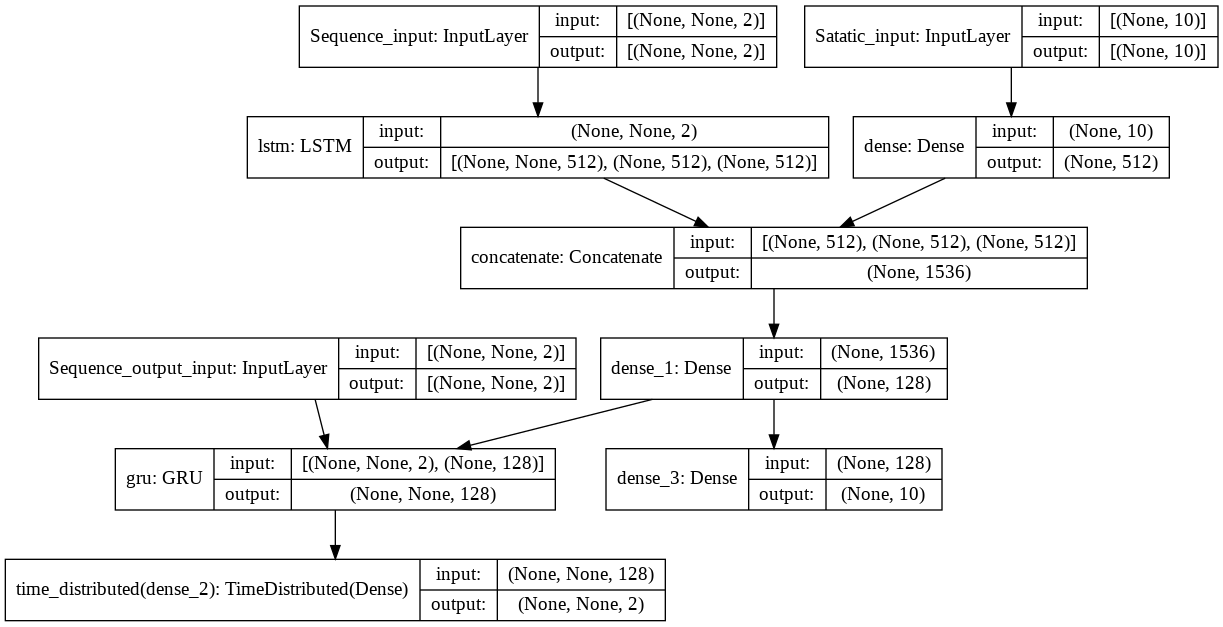

In [10]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)